# "Euphotic zone residence time of Antarctic Bottom Water"

### Code for Figure 3 probability density plots
Euphotic zone residence time of Lagrangian particles.

Corresponding to Yinghuan Xie (yinghuan.xie@utas.edu.au)

### Energy intensity threshold for euphotic zone

In [1]:
# E = hv = hc/lambda
import scipy.constants as const
# Defne constants
c      = const.c
h      = const.h #6.626e-34
lambda1= 400e-9  # 400-700nm visible light wavelength range
lambda2= 700e-9
mol    = const.Avogadro #6.02e23

# Assigned energy level (mol/m^2/day)
for Threshold in [2,3,4]:
    print('\nThreshold: ',Threshold,' mol/m^2/day')
    energy1 = Threshold*mol*h*c/(lambda1*86400)
    energy2 = Threshold*mol*h*c/(lambda2*86400)
    print('700nm corresponding: ',energy2,' W/m^2')
    print('400nm corresponding: ',energy1,' W/m^2')
    print('\n Middle estimate corresponding:',(energy2+energy1)/2),' W/m^2'



Threshold:  2  mol/m^2/day
700nm corresponding:  3.95590494836961  W/m^2
400nm corresponding:  6.922833659646817  W/m^2

 Middle estimate corresponding: 5.439369304008213

Threshold:  3  mol/m^2/day
700nm corresponding:  5.933857422554415  W/m^2
400nm corresponding:  10.384250489470226  W/m^2

 Middle estimate corresponding: 8.15905395601232

Threshold:  4  mol/m^2/day
700nm corresponding:  7.91180989673922  W/m^2
400nm corresponding:  13.845667319293634  W/m^2

 Middle estimate corresponding: 10.878738608016427


# Then we start the analysis

In [2]:
# Define the threshld for euphotic zone PAR in (watts per square metres)
# 2  mol/m^2/day: 5.439369304008213
# 3  mol/m^2/day: 8.15905395601232
# 4  mol/m^2/day: 10.878738608016427
PARZ_thre = 8.159
PARZ_thre_L = 5.439
PARZ_thre_U = 10.879

In [3]:
# Importing the relevant modules. 
import numpy as np
import xarray as xr
import os
import re
from glob import glob
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cosima_cookbook as cc
session =cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'
from os import sys
sys.path.append('/home/581/yx9454/PhD_Ch1')
from My_Py_Func import Ch1_defs as c1d

In [4]:
# In each experiment, we define 06-18, release-06, 05-release, 87-05,
# loop_start_point-87 (if availiable) as No 0,1,2,3,4(if availiable)

master_path = '/g/data/jk72/yx9454/runs/parcels/output_after_Aug/'
traj_input = {'MLS_ON':[{'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Following_MLS_ON/'},
                        {'out_freq': 5,
                        'exp_path':'CORE_Curtain_Forward(out_freq=5days)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Jan-Dec_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_MLS_ON/'},
                        {'out_freq': 0.25,
                        'exp_path':'CORE_Curtain_Backwards(out_freq=6hrs)_Following_Loop_MLS_ON/'}],
}

In [5]:
Chl_a_ver = 'Chl-a_based_on_OCCCI_v6'
var_in_arrs_0,var_in_arrs_1,var_in_arrs_2,var_in_arrs_3,var_in_arrs_4 = {},{},{},{},{}

for exp_name in ['MLS_ON']:
    files = sorted(glob('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/'+Chl_a_ver+'/var_in_arrs_*.npz'))

    var_in_arrs_list = [var_in_arrs_0,var_in_arrs_1,var_in_arrs_2,var_in_arrs_3,var_in_arrs_4]
    for i in [0,1,2,3,4]:
        print(files[i])
        for pvar in ['PARS','PARZ','Pt_ind']:
            PVAR   = np.load(files[i])[pvar]
            var_in_arrs_list[i][exp_name+'_'+pvar]=PVAR
            print(pvar,' loaded')

/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_0_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_1_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_2_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_3_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded
/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/Chl-a_based_on_OCCCI_v6/var_in_arrs_4_AABW_only_PARS_Z.npz
PARS  loaded
PARZ  loaded
Pt_ind  loaded


In [6]:
MLS_ON_stopsign_list   = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/MLS_ON/stopsign_list_for_20yrs_150m_thre.npz')['stopsign_list']
CDW_inds_MLS_ON   = ~(np.isnan(MLS_ON_stopsign_list))

In [7]:
%%time
hist_freq = 7 #(days)
###-------------------------------------------------------------------------------------------###
total_shallower_than_EZD_days_back_only = {}
total_shallower_than_EZD_days           = {}
means                                   = {}
medians                                 = {}
p10s                                    = {}
p90s                                    = {}
hists                                   = {}
###-------------------------------------------------------------------------------------------###

### For PARZ_thre lower limit  ---------------------------------------------------------------###
for PARZ_info,PARZ_thre_here in zip(['PARZ_thre_L','PARZ_thre_U','PARZ_thre'],
                                    [PARZ_thre_L,PARZ_thre_U,PARZ_thre]):

    # Backwards following
    #total_seconds = (T1 - dt.datetime(1970,1,1)).total_seconds()
    ind_t = -1
    out_freq = traj_input[exp_name][3]['out_freq']
    following    = np.sum(var_in_arrs_3[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here,axis=1)*out_freq
    
    # Backwards first year
    out_freq = traj_input[exp_name][2]['out_freq']
    first_yr = np.sum((var_in_arrs_2[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
    
    #The loop exp, starts from 2018-12-1
    ind_t = -1
    
    out_freq = traj_input[exp_name][4]['out_freq']
    loop = np.sum((var_in_arrs_4[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
    
    # Forwards first year
    if True:
        out_freq = traj_input[exp_name][0]['out_freq']
        following_forward = np.sum((var_in_arrs_0[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
    
    # Forwards following
    if True:
        ind_t = -1
        out_freq = traj_input[exp_name][1]['out_freq']
        first_yr_forward = np.sum((var_in_arrs_1[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
    
    total_shallower_than_EZD_days_back_only[PARZ_info] = following + first_yr + loop
    total_shallower_than_EZD_days[PARZ_info]           = following + first_yr + following_forward + first_yr_forward + loop
    
    AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds_MLS_ON)
    
    
    mean_lower = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
    hist_lower = np.histogram(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,bins=np.arange(0,365,hist_freq),density= True)
    
    
    hists[PARZ_info] = np.histogram(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,bins=np.arange(0,365,hist_freq),density= True)
    means[PARZ_info] = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
    medians[PARZ_info] = np.median(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
    p10s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,10)
    p90s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,90)

    print(PARZ_info,' calculation done')

PARZ_thre_L  calculation done
PARZ_thre_U  calculation done
PARZ_thre  calculation done
CPU times: user 31 s, sys: 5.23 s, total: 36.2 s
Wall time: 36.2 s


MLS_ON
PARZ_thre_L
Eligible AABW: 34665 particles
Eligible AABW: 52.973027549401415 days
Eligible AABW also in CDW: 30215 particles
Eligible AABW also in CDW: 48.958944232996856 days
PARZ_thre_U
Eligible AABW: 27892 particles
Eligible AABW: 35.85011831349491 days
Eligible AABW also in CDW: 23951 particles
Eligible AABW also in CDW: 33.75976994697508 days
PARZ_thre
Eligible AABW: 30950 particles
Eligible AABW: 41.95373182552504 days
Eligible AABW also in CDW: 26733 particles
Eligible AABW also in CDW: 39.12141360864849 days


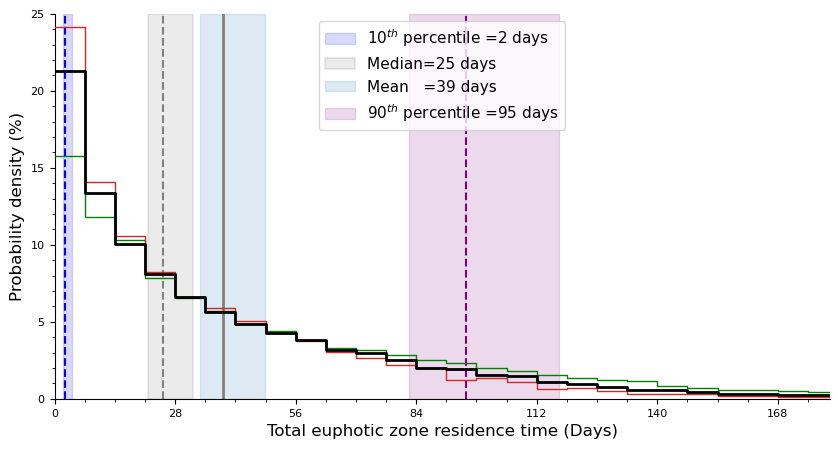

In [8]:
#Ver2
exp_names = ['MLS_ON']
CDW_inds_s = [CDW_inds_MLS_ON]
hist_freq = 7 #(days)
# Final Figure2
plt.figure(figsize=(10,5))

ax = plt.subplot(1, 1, 1)
for i in [0]:
    exp_name = exp_names[i]
    CDW_inds= CDW_inds_s[i]
    print(exp_name)

    #
    zorder=10
    for PARZ_info,color,linewidth,label in zip(['PARZ_thre_L','PARZ_thre_U','PARZ_thre'],['g','C3','k'],[1.,1.,2],
                                              ['Lower estimate','Upper estimate','Middle estimate']):
        #
        print(PARZ_info)
        AABW_shallower_than_EZD =  (total_shallower_than_EZD_days[PARZ_info]>0)
        print('Eligible AABW:',sum(AABW_shallower_than_EZD),'particles')
        print('Eligible AABW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD]),'days')
    
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds)
        print('Eligible AABW also in CDW:',sum(AABW_shallower_than_EZD_plus_CDW),'particles')
        print('Eligible AABW also in CDW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW])/1,'days')

    
        
        # Let the sum of hist1 equals to 1
        hist_value =  hists[PARZ_info][0]
        hist_value = hist_value*hist_freq
        # The let the sum of hist1 equals to 100 (%)
        hist_value = hist_value*100
        #
        #plt.plot(((hist1[1][1:]+hist1[1][:-1])/2),hist_value, zorder=10,color='k',linewidth=2,label='Probablity density')
        # Gets the upper edge of the histogram
        bin_centers = (hists[PARZ_info][1][:-1] + hists[PARZ_info][1][1:]) / 2
        # Add the left boundary of the first bin and the first count before bin_centers and counts, respectively
        bin_centers = np.insert(bin_centers, 0, hists[PARZ_info][1][0])
        hist_value = np.insert(hist_value, 0, hist_value[0])
        # Plot the upper edge of the histogram
        plt.step(bin_centers, hist_value, where='mid',zorder=zorder ,color=color,linewidth=linewidth) #label='3 mol/(m$^{2}\cdot$day)'
        zorder +=1


    # Plot stastics as vertical line
    
    
    plt.axvspan(p10s['PARZ_thre_L'], p10s['PARZ_thre_U'], color='b', alpha=0.15,label='10$^{th}$ percentile ='+str(int(p10s['PARZ_thre']))+' days')
    plt.plot(np.ones(10)*p10s['PARZ_thre'],
            np.arange(0,40000,4000),'--',color='b',linewidth=1.5)

    plt.axvspan(medians['PARZ_thre_L'], medians['PARZ_thre_U'], color='C7', alpha=0.15,linewidth=1.5,label= 'Median='+str(int(medians['PARZ_thre']*1))+' days')
    plt.plot(np.ones(10)*medians['PARZ_thre'],
            np.arange(0,40000,4000),'--',color='grey')

    plt.axvspan(means['PARZ_thre_L'], means['PARZ_thre_U'], color='C0', alpha=0.15,label='Mean   ='+str(int(means['PARZ_thre']*1))+' days')
    plt.plot(np.ones(10)*means['PARZ_thre'],
            np.arange(0,40000,4000),'grey',linewidth=2)

    
    plt.axvspan(p90s['PARZ_thre_L'], p90s['PARZ_thre_U'], color='purple', alpha=0.15,label='90$^{th}$ percentile ='+str(int(p90s['PARZ_thre']))+' days')
    plt.plot(np.ones(10)*p90s['PARZ_thre'],
            np.arange(0,40000,4000),'--',color='purple',linewidth=1.5)
    

#plt.ylim([0,hist2[0].max()])
plt.ylim([0,25])
plt.xlim([0,180])

majors = np.arange(0,730,28)
ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
minors = np.arange(0,730,7)
ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))

majors = np.arange(0,50,5)
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
minors = np.arange(0,50,1)
ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))

plt.legend(fontsize=11,loc='upper center')
plt.xlabel('Total euphotic zone residence time (Days)',fontsize=12)
plt.ylabel('Probability density (%)',fontsize=12)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('Revision_Figure_3_Probability_density_ver2.png',dpi=500)

MLS_ON
PARZ_thre_L
Eligible AABW: 34665 particles
Eligible AABW: 52.973027549401415 days
Eligible AABW also in CDW: 30215 particles
Eligible AABW also in CDW: 48.958944232996856 days
PARZ_thre_U
Eligible AABW: 27892 particles
Eligible AABW: 35.85011831349491 days
Eligible AABW also in CDW: 23951 particles
Eligible AABW also in CDW: 33.75976994697508 days
PARZ_thre
Eligible AABW: 30950 particles
Eligible AABW: 41.95373182552504 days
Eligible AABW also in CDW: 26733 particles
Eligible AABW also in CDW: 39.12141360864849 days


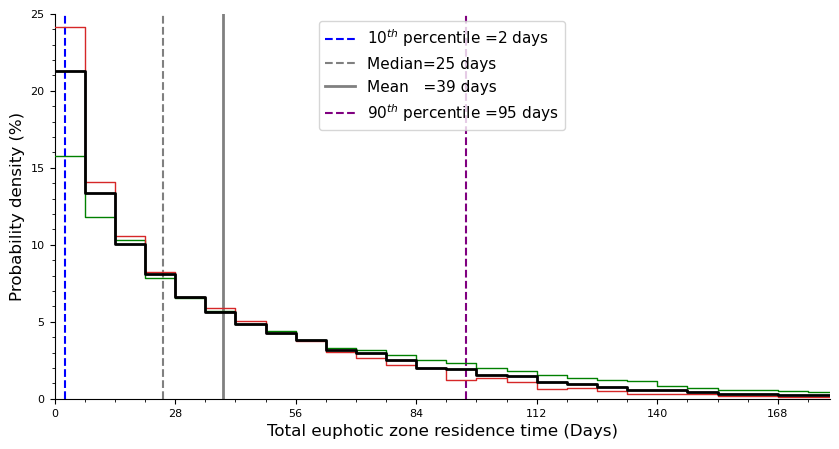

In [9]:
#Ver2 Simple version
exp_names = ['MLS_ON']
CDW_inds_s = [CDW_inds_MLS_ON]
hist_freq = 7 #(days)
# Final Figure2
plt.figure(figsize=(10,5))

ax = plt.subplot(1, 1, 1)
for i in [0]:
    exp_name = exp_names[i]
    CDW_inds= CDW_inds_s[i]
    print(exp_name)

    #
    zorder=10
    for PARZ_info,color,linewidth,label in zip(['PARZ_thre_L','PARZ_thre_U','PARZ_thre'],['g','C3','k'],[1.,1.,2],
                                              ['Lower estimate','Upper estimate','Middle estimate']):
        #
        print(PARZ_info)
        AABW_shallower_than_EZD =  (total_shallower_than_EZD_days[PARZ_info]>0)
        print('Eligible AABW:',sum(AABW_shallower_than_EZD),'particles')
        print('Eligible AABW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD]),'days')
    
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds)
        print('Eligible AABW also in CDW:',sum(AABW_shallower_than_EZD_plus_CDW),'particles')
        print('Eligible AABW also in CDW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW])/1,'days')

    
        
        # Let the sum of hist1 equals to 1
        hist_value =  hists[PARZ_info][0]
        hist_value = hist_value*hist_freq
        # The let the sum of hist1 equals to 100 (%)
        hist_value = hist_value*100
        #
        #plt.plot(((hist1[1][1:]+hist1[1][:-1])/2),hist_value, zorder=10,color='k',linewidth=2,label='Probablity density')
        # Gets the upper edge of the histogram
        bin_centers = (hists[PARZ_info][1][:-1] + hists[PARZ_info][1][1:]) / 2
        # Add the left boundary of the first bin and the first count before bin_centers and counts, respectively
        bin_centers = np.insert(bin_centers, 0, hists[PARZ_info][1][0])
        hist_value = np.insert(hist_value, 0, hist_value[0])
        # Plot the upper edge of the histogram
        plt.step(bin_centers, hist_value, where='mid',zorder=zorder ,color=color,linewidth=linewidth) #label='3 mol/(m$^{2}\cdot$day)'
        zorder +=1


    # Plot stastics as vertical line
    plt.plot(np.ones(10)*p10s['PARZ_thre'],
            np.arange(0,40000,4000),'--',color='b',linewidth=1.5,label='10$^{th}$ percentile ='+str(int(p10s['PARZ_thre']))+' days')

    plt.plot(np.ones(10)*medians['PARZ_thre'],
            np.arange(0,40000,4000),'--',color='grey',label= 'Median='+str(int(medians['PARZ_thre']*1))+' days')

    plt.plot(np.ones(10)*means['PARZ_thre'],
            np.arange(0,40000,4000),'grey',linewidth=2,label='Mean   ='+str(int(means['PARZ_thre']*1))+' days')

    plt.plot(np.ones(10)*p90s['PARZ_thre'],
            np.arange(0,40000,4000),'--',color='purple',linewidth=1.5,label='90$^{th}$ percentile ='+str(int(p90s['PARZ_thre']))+' days')
    

#plt.ylim([0,hist2[0].max()])
plt.ylim([0,25])
plt.xlim([0,180])

majors = np.arange(0,730,28)
ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
minors = np.arange(0,730,7)
ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))

majors = np.arange(0,50,5)
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
minors = np.arange(0,50,1)
ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))

plt.legend(fontsize=11,loc='upper center')
plt.xlabel('Total euphotic zone residence time (Days)',fontsize=12)
plt.ylabel('Probability density (%)',fontsize=12)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('Revision_Figure_3_Probability_density_ver2_Simple.png',dpi=500)

In [ ]:
#Ver2
p10s['MLS_ON'] += 0.1 # This is to ensure that the P10 lines for the 1998 and 2005 releases are distinguishable, as they would otherwise overlap.

# Final Figure2
plt.figure(figsize=(10,5))

ax = plt.subplot(1, 1, 1)
for i in [0]:
    exp_name = exp_names[i]
    #CDW_inds= CDW_inds_s[i]
    print(exp_name)

    #
    zorder=10
    for PARZ_info,color,linewidth,label in zip(['MLS_1998','MLS_2009','MLS_ON'],['b','r','k'],[1.,1.,1.5],
                                              ['1998 release','2009 release','2005 release']):
        #
        print(PARZ_info)
        AABW_shallower_than_EZD =  (total_shallower_than_EZD_days[PARZ_info]>0)
        print('Eligible AABW:',sum(AABW_shallower_than_EZD),'particles')
        print('Eligible AABW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD]),'days')
    
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) #& (CDW_inds)
        print('Eligible AABW also in CDW:',sum(AABW_shallower_than_EZD_plus_CDW),'particles')
        print('Eligible AABW also in CDW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW])/1,'days')

    
        
        # Let the sum of hist1 equals to 1
        hist_value =  hists[PARZ_info][0]
        hist_value = hist_value*hist_freq
        # The let the sum of hist1 equals to 100 (%)
        hist_value = hist_value*100
        #
        #plt.plot(((hist1[1][1:]+hist1[1][:-1])/2),hist_value, zorder=10,color='k',linewidth=2,label='Probablity density')
        # Gets the upper edge of the histogram
        bin_centers = (hists[PARZ_info][1][:-1] + hists[PARZ_info][1][1:]) / 2
        # Add the left boundary of the first bin and the first count before bin_centers and counts, respectively
        bin_centers = np.insert(bin_centers, 0, hists[PARZ_info][1][0])
        hist_value = np.insert(hist_value, 0, hist_value[0])
        # Plot the upper edge of the histogram
        plt.step(bin_centers, hist_value, where='mid',zorder=zorder ,color=color,linewidth=linewidth,label=label+'\n mean = '+str(round(means[PARZ_info], 1))+' days') #label='3 mol/(m$^{2}\cdot$day)'
        zorder +=1

        # Plot stastics as vertical line
        plt.plot(np.ones(10)*p10s[PARZ_info],
                np.arange(0,40000,4000),'--',color=color,linewidth=1.5)
    
        #plt.plot(np.ones(10)*medians[PARZ_info],
        #        np.arange(0,40000,4000),'--',color=color)
    
        plt.plot(np.ones(10)*means[PARZ_info],
                np.arange(0,40000,4000),color,linewidth=3)
    
        plt.plot(np.ones(10)*p90s[PARZ_info],
                np.arange(0,40000,4000),'--',color=color,linewidth=1.5)

#plt.ylim([0,hist2[0].max()])
plt.ylim([0,7.5])
plt.xlim([0,190])

majors = np.arange(0,730,28)
ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
minors = np.arange(0,730,7)
ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))

majors = np.arange(0,50,5)
ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
minors = np.arange(0,50,1)
ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))

plt.legend(fontsize=11,loc='upper left')
plt.xlabel('Total euphotic zone residence time (Days)',fontsize=12)
plt.ylabel('Probability density (%)',fontsize=12)

ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('Revision_Figure_3_Probability_density_'+exp_name+'.png',dpi=500)

### Sensitivity test for reviewer's question:
"L135-136: The unbeaching procedure is rather unphysical. Dawson et al. found that a large fraction of particles were getting beached in the shelf, although the statistics of interest to that study were not strongly affected by this. Can you assert what the sensitivity of your results was or might be?"

In [7]:
unbeachCount = np.load('/g/data/jk72/yx9454/Euphotic_zone_research_trajectory_in_npz/MLS_ON/var_in_arrs_unbeachCount_ONE_TimeSnapshot.npz')

In [23]:
AABW_inds = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/AABW_inds.npz')['AABW_inds']


In [18]:
int_unbeachCount = ((unbeachCount['var_in_arrs_0'][:-1]) +
                    (unbeachCount['var_in_arrs_1'][:-1]) +
                    (unbeachCount['var_in_arrs_2'][:-1]) +
                    (unbeachCount['var_in_arrs_4']) )

num = np.nansum(int_unbeachCount>0)
print(num,)

763073


array([nan,  2.,  0., ..., 27.,  0., nan])

In [35]:
%%time
hist_freq = 7 #(days)
# Costimized part for int_unbeachCount
for unbeachCount_thre in  [100,496]:
    print('unbeachCount_thre: ',unbeachCount_thre)
    int_unbeachCount_aabw = np.append(int_unbeachCount,np.nan)[AABW_inds]
    
    int_unbeachCount_aabw_inds = int_unbeachCount_aabw>unbeachCount_thre
    
    ###-------------------------------------------------------------------------------------------###
    total_shallower_than_EZD_days_back_only = {}
    total_shallower_than_EZD_days           = {}
    means                                   = {}
    medians                                 = {}
    p10s                                    = {}
    p90s                                    = {}
    hists                                   = {}
    ###-------------------------------------------------------------------------------------------###
    
    ### For PARZ_thre lower limit  ---------------------------------------------------------------###
    for PARZ_info,PARZ_thre_here in zip(['PARZ_thre_L','PARZ_thre_U','PARZ_thre'],
                                        [PARZ_thre_L,PARZ_thre_U,PARZ_thre]):
    
        # Backwards following
        #total_seconds = (T1 - dt.datetime(1970,1,1)).total_seconds()
        ind_t = -1
        out_freq = traj_input[exp_name][3]['out_freq']
        following    = np.sum(var_in_arrs_3[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here,axis=1)*out_freq
        
        # Backwards first year
        out_freq = traj_input[exp_name][2]['out_freq']
        first_yr = np.sum((var_in_arrs_2[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
        
        #The loop exp, starts from 2018-12-1
        ind_t = -1
        
        out_freq = traj_input[exp_name][4]['out_freq']
        loop = np.sum((var_in_arrs_4[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
        
        # Forwards first year
        if True:
            out_freq = traj_input[exp_name][0]['out_freq']
            following_forward = np.sum((var_in_arrs_0[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
        
        # Forwards following
        if True:
            ind_t = -1
            out_freq = traj_input[exp_name][1]['out_freq']
            first_yr_forward = np.sum((var_in_arrs_1[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
        
        total_shallower_than_EZD_days_back_only[PARZ_info] = following + first_yr + loop
        total_shallower_than_EZD_days[PARZ_info]           = following + first_yr + following_forward + first_yr_forward + loop
        
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds_MLS_ON & ~int_unbeachCount_aabw_inds)
        
        
        mean_lower = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        hist_lower = np.histogram(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,bins=np.arange(0,365,hist_freq),density= True)
        
        
        #hists[PARZ_info] = np.histogram(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,bins=np.arange(0,365,hist_freq),density= True)
        means[PARZ_info] = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        #medians[PARZ_info] = np.median(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        #p10s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,10)
        #p90s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,90)
    
        print(PARZ_info,' calculation done')
        print(means)

unbeachCount_thre:  100
PARZ_thre_L  calculation done
{'PARZ_thre_L': 46.830426025158665}
PARZ_thre_U  calculation done
{'PARZ_thre_L': 46.830426025158665, 'PARZ_thre_U': 32.22278539478802}
PARZ_thre  calculation done
{'PARZ_thre_L': 46.830426025158665, 'PARZ_thre_U': 32.22278539478802, 'PARZ_thre': 37.368506493506494}
unbeachCount_thre:  496
PARZ_thre_L  calculation done
{'PARZ_thre_L': 48.358828322757375}
PARZ_thre_U  calculation done
{'PARZ_thre_L': 48.358828322757375, 'PARZ_thre_U': 33.30866584637019}
PARZ_thre  calculation done
{'PARZ_thre_L': 48.358828322757375, 'PARZ_thre_U': 33.30866584637019, 'PARZ_thre': 38.61308447937132}
CPU times: user 40.6 s, sys: 7.67 s, total: 48.3 s
Wall time: 48.3 s


{'PARZ_thre_L': 48.358828322757375,
 'PARZ_thre_U': 33.30866584637019,
 'PARZ_thre': 38.61308447937132}

## Build the 4 regions mask

In [10]:
print('point munber along contour:',933504/(12*13))
region_no = (np.array(list(np.arange(1,5985))*13*12)/300).astype(int)+1
wedd_ind =  (region_no<=15) & (region_no>=12)
print('wedd_ind',sum(wedd_ind))
prydz_ind =  (region_no==20) | (region_no==1)
print('prydz_ind',sum(prydz_ind))
adelie_ind =  (region_no<=4) & (region_no>=3)
print('adelie_ind',sum(adelie_ind))
ross_ind =  (region_no<=7) & (region_no>=5)
print('wedd_ind',sum(wedd_ind))

point munber along contour: 5984.0
wedd_ind 187200
prydz_ind 91104
adelie_ind 93600
wedd_ind 187200


In [11]:
AABW_inds_s = {}
for exp_name in ['MLS_ON']:
    AABW_inds_s[exp_name] = np.load('/g/data/jk72/yx9454/PAR_from_iaf_cycle4/'+exp_name+'/AABW_inds.npz')['AABW_inds']

In [12]:
%%time
hist_freq = 7 #(days)
###-------------------------------------------------------------------------------------------###
total_shallower_than_EZD_days_back_only = {}
total_shallower_than_EZD_days           = {}
means                                   = {}
medians                                 = {}
p10s                                    = {}
p90s                                    = {}
hists                                   = {}
###-------------------------------------------------------------------------------------------###

### For PARZ_thre lower limit  ---------------------------------------------------------------###


region_names=['Weddell_Sea','Prydz_Bay','Adelie_Coast','Ross_Sea']
region_inds = [wedd_ind,prydz_ind,adelie_ind,ross_ind]

for ii in [0,1,2,3]:
    region_inds_AABW = region_inds[ii]
    region_inds_AABW = region_inds_AABW[AABW_inds_s[exp_name]]

    for PARZ_info,PARZ_thre_here in zip([region_names[ii]+'_PARZ_thre_L',region_names[ii]+'_PARZ_thre_U',region_names[ii]+'_PARZ_thre'],
                                        [PARZ_thre_L,PARZ_thre_U,PARZ_thre]):
        
    
    
        # Backwards following
        #total_seconds = (T1 - dt.datetime(1970,1,1)).total_seconds()
        ind_t = -1
        out_freq = traj_input[exp_name][3]['out_freq']
        following    = np.sum(var_in_arrs_3[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here,axis=1)*out_freq
        
        # Backwards first year
        out_freq = traj_input[exp_name][2]['out_freq']
        first_yr = np.sum((var_in_arrs_2[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
        
        #The loop exp, starts from 2018-12-1
        ind_t = -1
        
        out_freq = traj_input[exp_name][4]['out_freq']
        loop = np.sum((var_in_arrs_4[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
        
        # Forwards first year
        if True:
            out_freq = traj_input[exp_name][0]['out_freq']
            following_forward = np.sum((var_in_arrs_0[exp_name+'_PARZ'][:,:]>PARZ_thre_here),axis=1)*out_freq
        
        # Forwards following
        if True:
            ind_t = -1
            out_freq = traj_input[exp_name][1]['out_freq']
            first_yr_forward = np.sum((var_in_arrs_1[exp_name+'_PARZ'][:,:ind_t]>PARZ_thre_here),axis=1)*out_freq
        
        total_shallower_than_EZD_days_back_only[PARZ_info] = following + first_yr + loop
        total_shallower_than_EZD_days[PARZ_info]           = following + first_yr + following_forward + first_yr_forward + loop
        
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds_MLS_ON & region_inds_AABW)
        
        
        mean_lower = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        hist_lower = np.histogram(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,bins=np.arange(0,365,hist_freq),density= True)
        
        
        hists[PARZ_info] = np.histogram(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,bins=np.arange(0,365,hist_freq),density= True)
        means[PARZ_info] = np.mean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        medians[PARZ_info] = np.median(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1)
        p10s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,10)
        p90s[PARZ_info] = np.percentile(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW]/1,90)
    
        print(PARZ_info,' calculation done')

Weddell_Sea_PARZ_thre_L  calculation done
Weddell_Sea_PARZ_thre_U  calculation done
Weddell_Sea_PARZ_thre  calculation done
Prydz_Bay_PARZ_thre_L  calculation done
Prydz_Bay_PARZ_thre_U  calculation done
Prydz_Bay_PARZ_thre  calculation done
Adelie_Coast_PARZ_thre_L  calculation done
Adelie_Coast_PARZ_thre_U  calculation done
Adelie_Coast_PARZ_thre  calculation done
Ross_Sea_PARZ_thre_L  calculation done
Ross_Sea_PARZ_thre_U  calculation done
Ross_Sea_PARZ_thre  calculation done
CPU times: user 1min 45s, sys: 20.2 s, total: 2min 5s
Wall time: 2min 5s


###--------------------------- AABW Formation region:  Weddell_Sea   ---------------------------###
Weddell_Sea_PARZ_thre_L
Eligible AABW: 11642 particles
Eligible AABW: 70.26492441161312 days
Eligible AABW also in CDW: 9692 particles
Eligible AABW also in CDW: 32.92139135369377 days
Weddell_Sea_PARZ_thre_U
Eligible AABW: 10276 particles
Eligible AABW: 45.733213312572985 days
Eligible AABW also in CDW: 8480 particles
Eligible AABW also in CDW: 21.645341981132077 days
Weddell_Sea_PARZ_thre
Eligible AABW: 10990 particles
Eligible AABW: 54.31146496815287 days
Eligible AABW also in CDW: 9102 particles
Eligible AABW also in CDW: 25.59522632388486 days
###--------------------------- AABW Formation region:  Prydz_Bay   ---------------------------###
Prydz_Bay_PARZ_thre_L
Eligible AABW: 5703 particles
Eligible AABW: 57.98496405400666 days
Eligible AABW also in CDW: 5121 particles
Eligible AABW also in CDW: 27.55460359304823 days
Prydz_Bay_PARZ_thre_U
Eligible AABW: 4950 particles
Eligible AABW

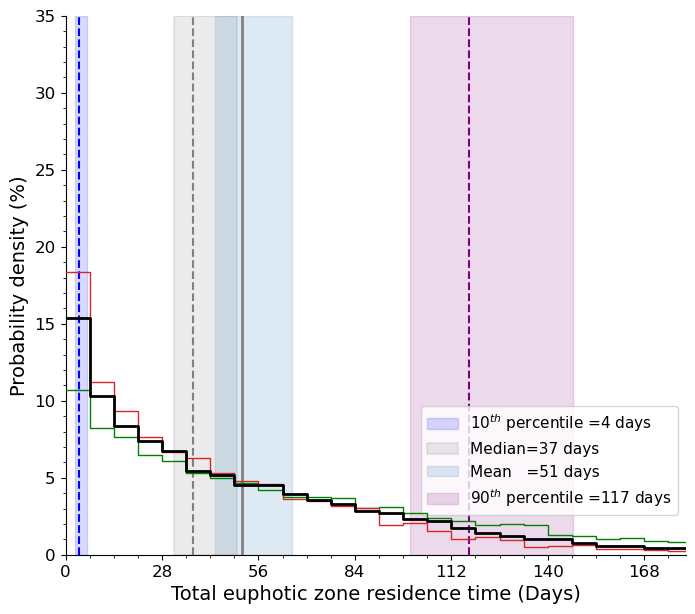

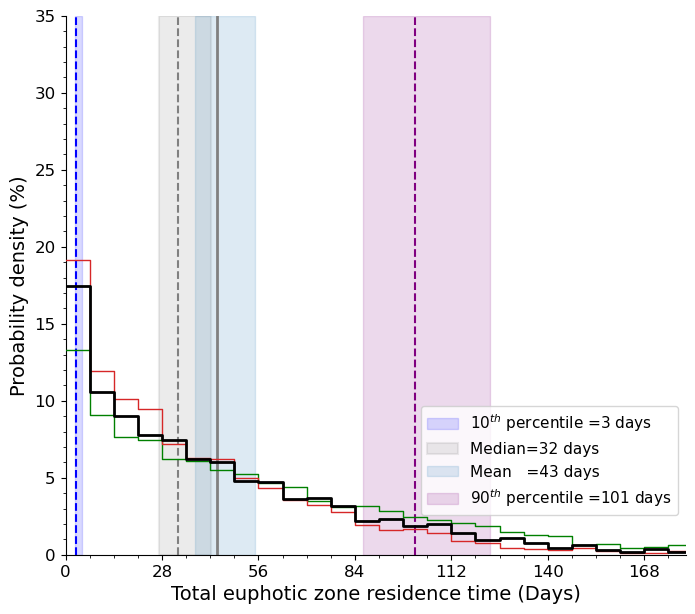

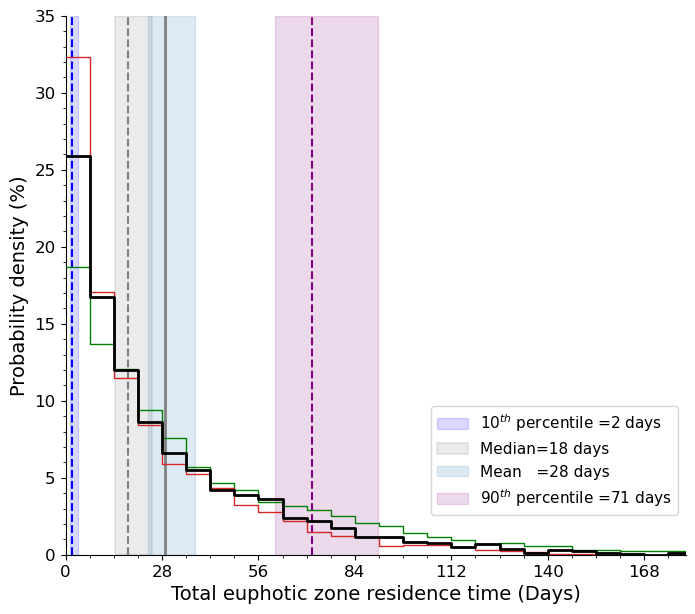

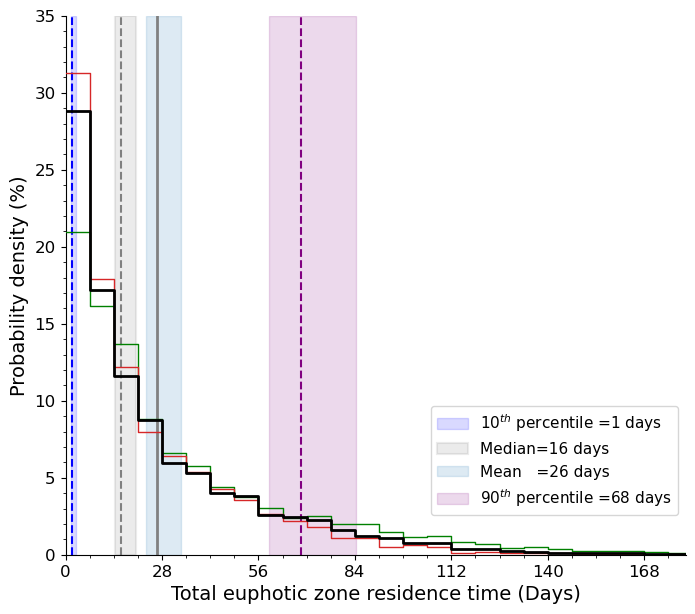

In [13]:
%%time
hist_freq = 7 #(days)

region_names=['Weddell_Sea','Prydz_Bay','Adelie_Coast','Ross_Sea']
region_inds = [wedd_ind,prydz_ind,adelie_ind,ross_ind]

for ii in [0,1,2,3]:
    region_inds_AABW = region_inds[ii]
    region_inds_AABW = region_inds_AABW[AABW_inds_s[exp_name]]
    print('###--------------------------- AABW Formation region: ',region_names[ii],'  ---------------------------###')
    # Figure2 Plots for 4 regions
    plt.figure(figsize=(8,7))
    ax = plt.subplot(1, 1, 1)

    #
    zorder=10
    for PARZ_info,color,linewidth,label in zip([region_names[ii]+'_PARZ_thre_L',region_names[ii]+'_PARZ_thre_U',region_names[ii]+'_PARZ_thre'],['g','C3','k'],[1,1,2],
                                              ['Lower estimate','Upper estimate','Middle estimate']):
        #
        print(PARZ_info)
        AABW_shallower_than_EZD =  (total_shallower_than_EZD_days[PARZ_info]>0)
        print('Eligible AABW:',sum(AABW_shallower_than_EZD & region_inds_AABW),'particles')
        print('Eligible AABW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD & region_inds_AABW]),'days')
    
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds)
        print('Eligible AABW also in CDW:',sum(AABW_shallower_than_EZD_plus_CDW & region_inds_AABW),'particles')
        print('Eligible AABW also in CDW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW & region_inds_AABW])/2,'days')

    
        
        # Let the sum of hist1 equals to 1
        hist_value =  hists[PARZ_info][0]
        hist_value = hist_value*hist_freq
        # The let the sum of hist1 equals to 100 (%)
        hist_value = hist_value*100
        #
        #plt.plot(((hist1[1][1:]+hist1[1][:-1])/2),hist_value, zorder=10,color='k',linewidth=2,label='Probablity density')
        # Gets the upper edge of the histogram
        bin_centers = (hists[PARZ_info][1][:-1] + hists[PARZ_info][1][1:]) / 2
        # Add the left boundary of the first bin and the first count before bin_centers and counts, respectively
        bin_centers = np.insert(bin_centers, 0, hists[PARZ_info][1][0])
        hist_value = np.insert(hist_value, 0, hist_value[0])
        # Plot the upper edge of the histogram
        plt.step(bin_centers, hist_value, where='mid',zorder=zorder ,color=color,linewidth=linewidth) #label='3 mol/(m$^{2}\cdot$day)'
        zorder +=1

    
    # Plot stastics as vertical line
    
    plt.axvspan(p10s[region_names[ii]+'_PARZ_thre_L'], p10s[region_names[ii]+'_PARZ_thre_U'], color='b', alpha=0.15,label='10$^{th}$ percentile ='+str(int(p10s[region_names[ii]+'_PARZ_thre']))+' days')
    plt.plot(np.ones(10)*p10s[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'--',color='b',linewidth=1.5)

    plt.axvspan(medians[region_names[ii]+'_PARZ_thre_L'], medians[region_names[ii]+'_PARZ_thre_U'], color='C7', alpha=0.15,linewidth=1.5,label= 'Median='+str(int(medians[region_names[ii]+'_PARZ_thre']*1))+' days')
    plt.plot(np.ones(10)*medians[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'--',color='grey')

    plt.axvspan(means[region_names[ii]+'_PARZ_thre_L'], means[region_names[ii]+'_PARZ_thre_U'], color='C0', alpha=0.15,label='Mean   ='+str(int(means[region_names[ii]+'_PARZ_thre']*1))+' days')
    plt.plot(np.ones(10)*means[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'grey',linewidth=2)

    
    plt.axvspan(p90s[region_names[ii]+'_PARZ_thre_L'], p90s[region_names[ii]+'_PARZ_thre_U'], color='purple', alpha=0.15,label='90$^{th}$ percentile ='+str(int(p90s[region_names[ii]+'_PARZ_thre']))+' days')
    plt.plot(np.ones(10)*p90s[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'--',color='purple',linewidth=1.5)
        
    
    #plt.ylim([0,hist2[0].max()])
    plt.ylim([0,35])
    plt.xlim([0,180])
    
    majors = np.arange(0,730,28)
    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
    minors = np.arange(0,730,7)
    ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
    
    majors = np.arange(0,50,5)
    ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
    minors = np.arange(0,50,1)
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))
    
    plt.legend(fontsize=11,loc='lower right',bbox_to_anchor=(1, 0.06))
    plt.xlabel('Total euphotic zone residence time (Days)',fontsize=14)
    plt.ylabel('Probability density (%)',fontsize=14)
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig('Review_Figure_3_Probability_density_'+region_names[ii]+'_ver2.png',dpi=500)

###--------------------------- AABW Formation region:  Weddell_Sea   ---------------------------###
Weddell_Sea_PARZ_thre_L
Eligible AABW: 11642 particles
Eligible AABW: 70.26492441161312 days
Eligible AABW also in CDW: 9692 particles
Eligible AABW also in CDW: 32.92139135369377 days
Weddell_Sea_PARZ_thre_U
Eligible AABW: 10276 particles
Eligible AABW: 45.733213312572985 days
Eligible AABW also in CDW: 8480 particles
Eligible AABW also in CDW: 21.645341981132077 days
Weddell_Sea_PARZ_thre
Eligible AABW: 10990 particles
Eligible AABW: 54.31146496815287 days
Eligible AABW also in CDW: 9102 particles
Eligible AABW also in CDW: 25.59522632388486 days
###--------------------------- AABW Formation region:  Prydz_Bay   ---------------------------###
Prydz_Bay_PARZ_thre_L
Eligible AABW: 5703 particles
Eligible AABW: 57.98496405400666 days
Eligible AABW also in CDW: 5121 particles
Eligible AABW also in CDW: 27.55460359304823 days
Prydz_Bay_PARZ_thre_U
Eligible AABW: 4950 particles
Eligible AABW

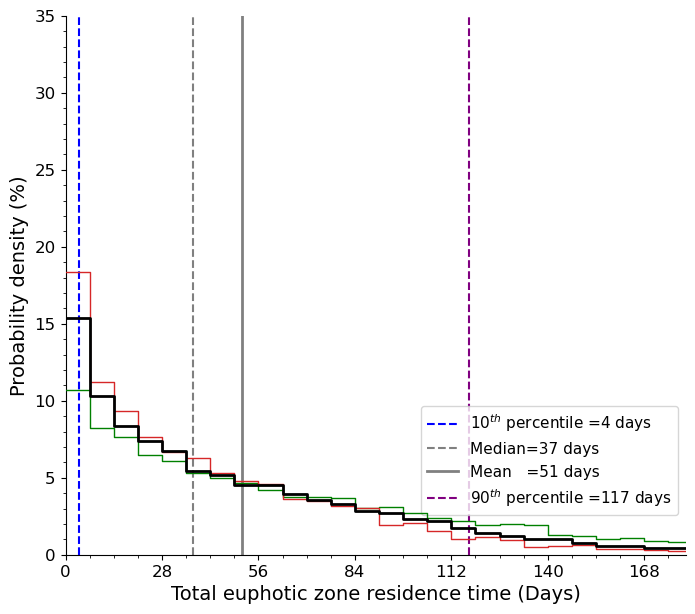

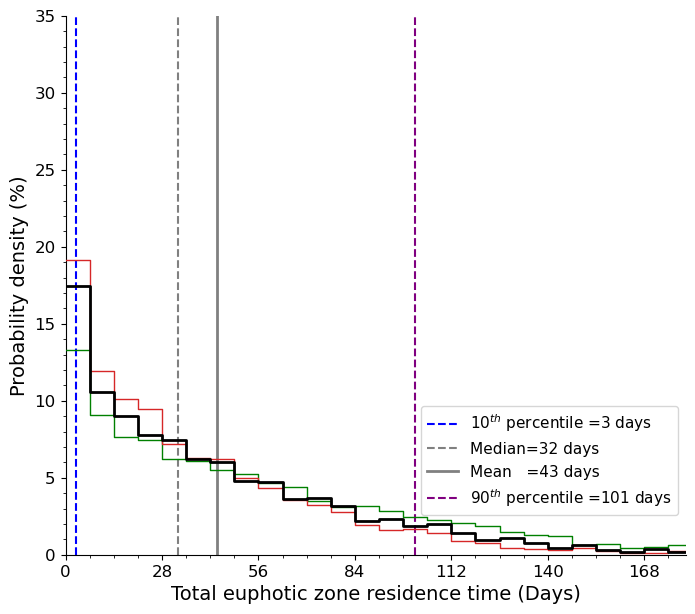

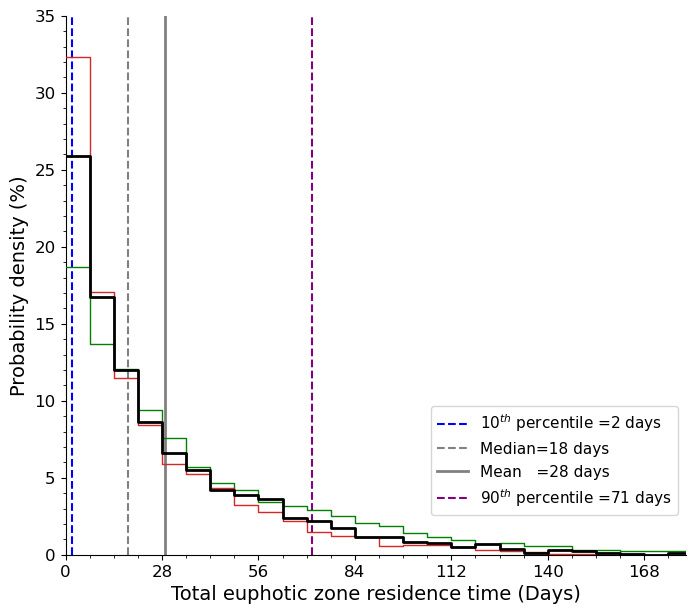

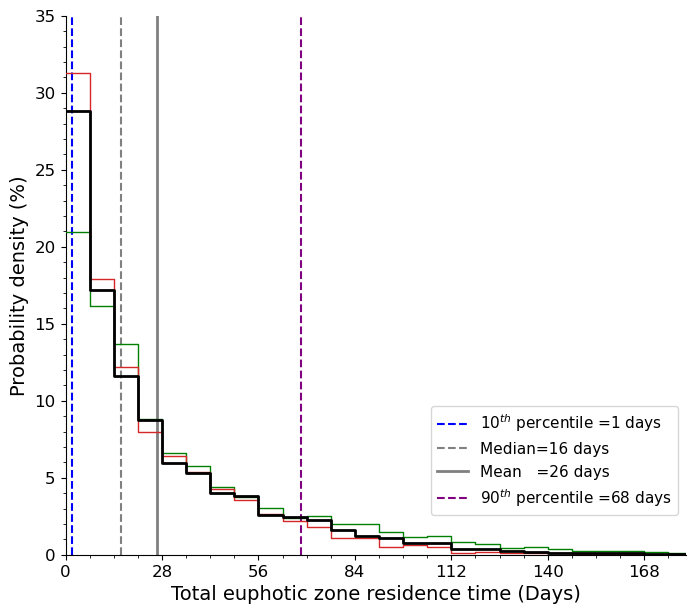

In [14]:
%%time
# Simple version
hist_freq = 7 #(days)

region_names=['Weddell_Sea','Prydz_Bay','Adelie_Coast','Ross_Sea']
region_inds = [wedd_ind,prydz_ind,adelie_ind,ross_ind]

for ii in [0,1,2,3]:
    region_inds_AABW = region_inds[ii]
    region_inds_AABW = region_inds_AABW[AABW_inds_s[exp_name]]
    print('###--------------------------- AABW Formation region: ',region_names[ii],'  ---------------------------###')
    # Figure2 Plots for 4 regions
    plt.figure(figsize=(8,7))
    ax = plt.subplot(1, 1, 1)

    #
    zorder=10
    for PARZ_info,color,linewidth,label in zip([region_names[ii]+'_PARZ_thre_L',region_names[ii]+'_PARZ_thre_U',region_names[ii]+'_PARZ_thre'],['g','C3','k'],[1,1,2],
                                              ['Lower estimate','Upper estimate','Middle estimate']):
        #
        print(PARZ_info)
        AABW_shallower_than_EZD =  (total_shallower_than_EZD_days[PARZ_info]>0)
        print('Eligible AABW:',sum(AABW_shallower_than_EZD & region_inds_AABW),'particles')
        print('Eligible AABW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD & region_inds_AABW]),'days')
    
        AABW_shallower_than_EZD_plus_CDW =  (total_shallower_than_EZD_days[PARZ_info]>0) & (CDW_inds)
        print('Eligible AABW also in CDW:',sum(AABW_shallower_than_EZD_plus_CDW & region_inds_AABW),'particles')
        print('Eligible AABW also in CDW:',np.nanmean(total_shallower_than_EZD_days[PARZ_info][AABW_shallower_than_EZD_plus_CDW & region_inds_AABW])/2,'days')

    
        
        # Let the sum of hist1 equals to 1
        hist_value =  hists[PARZ_info][0]
        hist_value = hist_value*hist_freq
        # The let the sum of hist1 equals to 100 (%)
        hist_value = hist_value*100
        #
        #plt.plot(((hist1[1][1:]+hist1[1][:-1])/2),hist_value, zorder=10,color='k',linewidth=2,label='Probablity density')
        # Gets the upper edge of the histogram
        bin_centers = (hists[PARZ_info][1][:-1] + hists[PARZ_info][1][1:]) / 2
        # Add the left boundary of the first bin and the first count before bin_centers and counts, respectively
        bin_centers = np.insert(bin_centers, 0, hists[PARZ_info][1][0])
        hist_value = np.insert(hist_value, 0, hist_value[0])
        # Plot the upper edge of the histogram
        plt.step(bin_centers, hist_value, where='mid',zorder=zorder ,color=color,linewidth=linewidth) #label='3 mol/(m$^{2}\cdot$day)'
        zorder +=1

    
    # Plot stastics as vertical line
    plt.plot(np.ones(10)*p10s[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'--',color='b',linewidth=1.5,label='10$^{th}$ percentile ='+str(int(p10s[region_names[ii]+'_PARZ_thre']))+' days')

    plt.plot(np.ones(10)*medians[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'--',color='grey',label= 'Median='+str(int(medians[region_names[ii]+'_PARZ_thre']*1))+' days')

    plt.plot(np.ones(10)*means[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'grey',linewidth=2,label='Mean   ='+str(int(means[region_names[ii]+'_PARZ_thre']*1))+' days')

    plt.plot(np.ones(10)*p90s[region_names[ii]+'_PARZ_thre'],
            np.arange(0,40000,4000),'--',color='purple',linewidth=1.5,label='90$^{th}$ percentile ='+str(int(p90s[region_names[ii]+'_PARZ_thre']))+' days')
        
    
    #plt.ylim([0,hist2[0].max()])
    plt.ylim([0,35])
    plt.xlim([0,180])
    
    majors = np.arange(0,730,28)
    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
    minors = np.arange(0,730,7)
    ax.xaxis.set_minor_locator(ticker.FixedLocator(minors))
    
    majors = np.arange(0,50,5)
    ax.yaxis.set_major_locator(ticker.FixedLocator(majors))
    minors = np.arange(0,50,1)
    ax.yaxis.set_minor_locator(ticker.FixedLocator(minors))
    
    plt.legend(fontsize=11,loc='lower right',bbox_to_anchor=(1, 0.06))
    plt.xlabel('Total euphotic zone residence time (Days)',fontsize=14)
    plt.ylabel('Probability density (%)',fontsize=14)
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig('Review_Figure_3_Probability_density_'+region_names[ii]+'_ver2_Simple.png',dpi=500)